In [1]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable



C:\Users\edmundlylee\AppData\Local\Temp\ipykernel_25788\1670400369.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')
C:\Users\edmundlylee\AppData\Local\Temp\ipykernel_25788\1670400369.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("data/{}.csv".format(symbol), index_col='DateTime',
                parse_dates=True, usecols=['DateTime', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

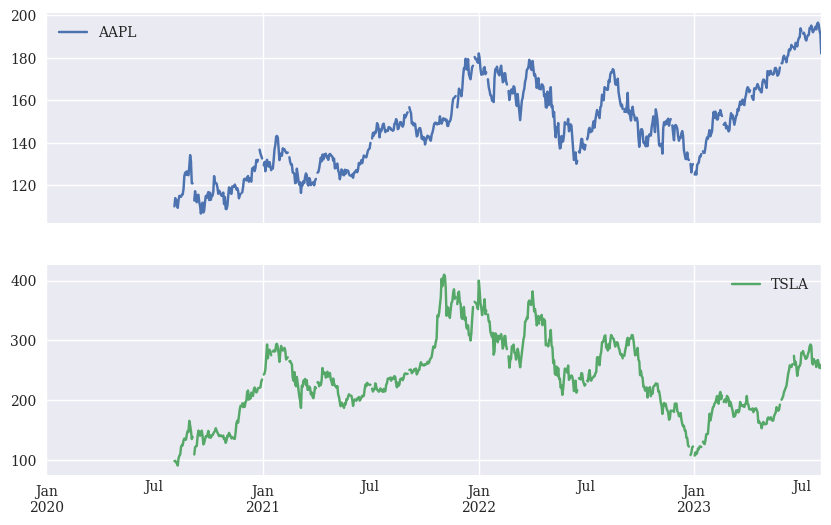

In [3]:
start_date = '2020-01-01'
end_date = '2023-08-04'
dates = pd.date_range(start_date,end_date,freq='B')
symbols = ['AAPL', 'TSLA']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);

In [4]:
df.tail()

,AAPL,TSLA
2023-07-31,196.47,267.49
2023-08-01,195.60,261.08
2023-08-02,192.58,254.15
2023-08-03,191.00,259.30
2023-08-04,181.99,253.85


In [5]:
df = {}
for symbol in symbols:
    df[symbol] = pd.read_csv("data/{}.csv".format(symbol), index_col='DateTime',
                    parse_dates=True, usecols=['DateTime', 'Close'], na_values=['nan'])
    df[symbol]=df[symbol].fillna(method='ffill')

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df[symbol]['Close'] = scaler.fit_transform(df[symbol]['Close'].values.reshape(-1,1))

In [6]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]



look_back = 120 # choose sequence length
x_train, y_train, x_test, y_test = {}, {}, {}, {}
for symbol in symbols:
    x_train[symbol], y_train[symbol], x_test[symbol], y_test[symbol] = load_data(df[symbol], look_back)
    # make training and test sets in torch
    x_train[symbol] = torch.from_numpy(x_train[symbol]).type(torch.Tensor)
    x_test[symbol] = torch.from_numpy(x_test[symbol]).type(torch.Tensor)
    y_train[symbol] = torch.from_numpy(y_train[symbol]).type(torch.Tensor)
    y_test[symbol] = torch.from_numpy(y_test[symbol]).type(torch.Tensor)
    y_train[symbol].size(),x_train[symbol].size()

In [7]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = {}
optimizer = {}
scheduler = {}

# Train model
#####################
num_epochs = 100

for symbol in symbols:
    model[symbol] = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

    loss_fn = torch.nn.MSELoss()
    optimizer[symbol] = torch.optim.Adam(model[symbol].parameters(), lr=0.01)
    scheduler[symbol] = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer[symbol], T_max=num_epochs)
# print(model)
# print(len(list(model.parameters())))
# for i in range(len(list(model.parameters()))):
#     print(list(model.parameters())[i].size())

Epoch  10 MSE:  0.02173367515206337
Epoch  20 MSE:  0.011648058891296387
Epoch  30 MSE:  0.008651171810925007
Epoch  40 MSE:  0.0068822335451841354
Epoch  50 MSE:  0.006037106737494469
Epoch  60 MSE:  0.0055315690115094185
Epoch  70 MSE:  0.005160414148122072
Epoch  80 MSE:  0.004862658679485321
Epoch  90 MSE:  0.004592128098011017


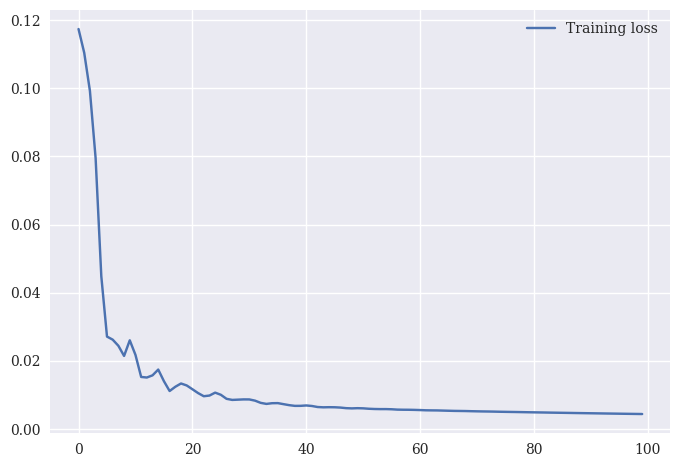

Epoch  10 MSE:  0.02380584552884102
Epoch  20 MSE:  0.01444491371512413
Epoch  30 MSE:  0.00847077090293169
Epoch  40 MSE:  0.007130937185138464
Epoch  50 MSE:  0.0063018337823450565
Epoch  60 MSE:  0.005871231202036142
Epoch  70 MSE:  0.0054639363661408424
Epoch  80 MSE:  0.00515141524374485
Epoch  90 MSE:  0.004871314857155085


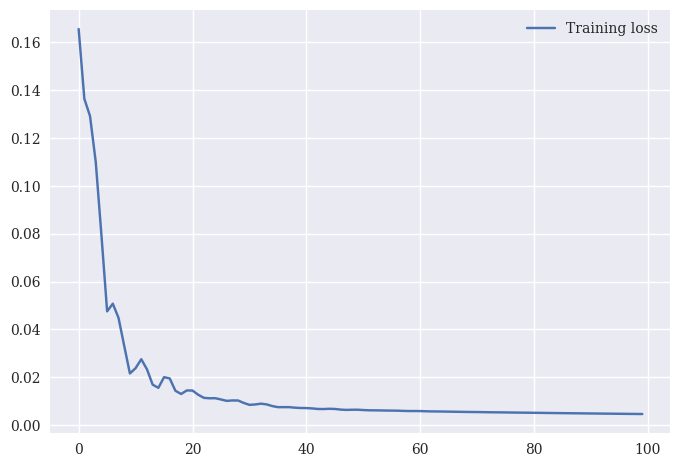

In [8]:


y_train_pred = {}
for symbol in symbols:
    hist = np.zeros(num_epochs)
    for t in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()
        
        # Forward pass
        y_train_pred[symbol] = model[symbol](x_train[symbol])

        loss = loss_fn(y_train_pred[symbol], y_train[symbol])
        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimizer[symbol].zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer[symbol].step()
    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()

In [9]:
y_test_pred = {}
for symbol in symbols:
    # make predictions
    y_test_pred[symbol] = model[symbol](x_test[symbol])

    # invert predictions
    y_train_pred[symbol] = scaler.inverse_transform(y_train_pred[symbol].detach().numpy())
    y_train[symbol] = scaler.inverse_transform(y_train[symbol].detach().numpy())
    y_test_pred[symbol] = scaler.inverse_transform(y_test_pred[symbol].detach().numpy())
    y_test[symbol] = scaler.inverse_transform(y_test[symbol].detach().numpy())

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[symbol][:,0], y_train_pred[symbol][:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[symbol][:,0], y_test_pred[symbol][:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.52 RMSE
Test Score: 9.77 RMSE
Train Score: 10.84 RMSE
Test Score: 7.75 RMSE


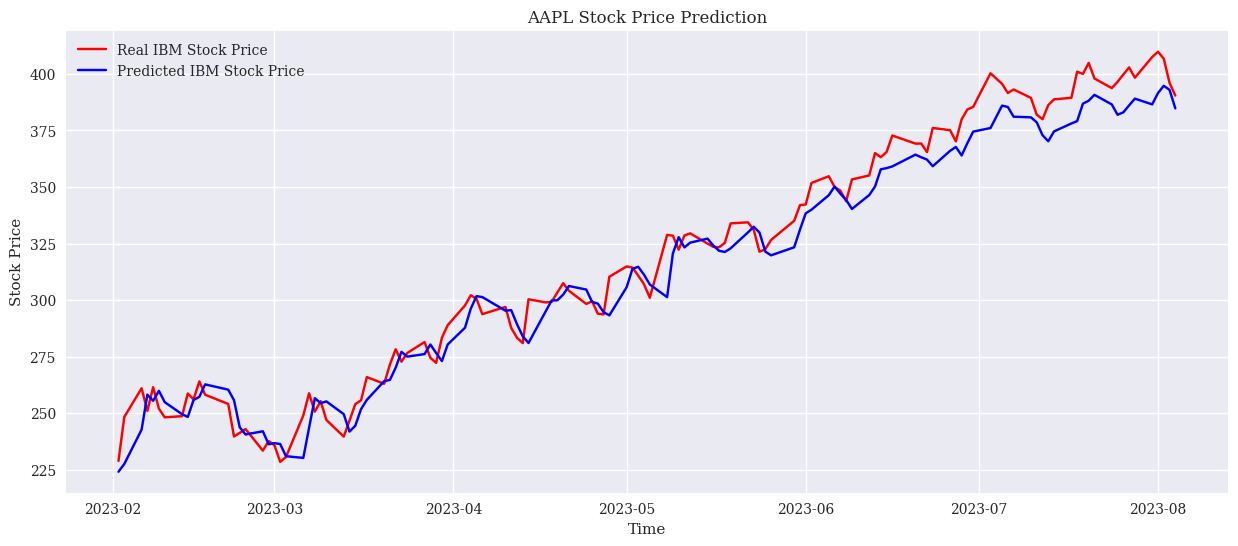

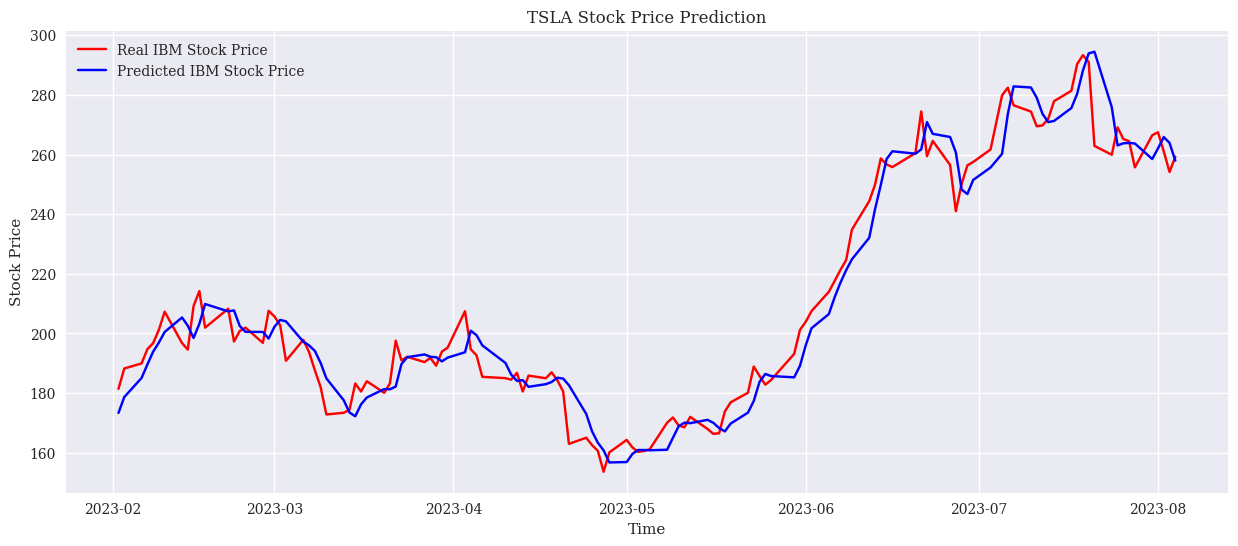

In [10]:
for symbol in symbols:
    # Visualising the results
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()

    axes.plot(df[symbol][len(df[symbol])-len(y_test[symbol]):].index, y_test[symbol], color = 'red', label = 'Real IBM Stock Price')
    axes.plot(df[symbol][len(df[symbol])-len(y_test[symbol]):].index, y_test_pred[symbol], color = 'blue', label = 'Predicted IBM Stock Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title(symbol + ' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    # plt.savefig('ibm_pred.png')
    plt.show()

In [11]:
y_test_pred = {}
for symbol in symbols:
    # # make predictions
    y_test_pred[symbol] = model[symbol](x_test[symbol])
    
    # print(x_test[symbol][0:1,:,:].shape)
    # print(x_test[symbol][0:1,:,:])
    x = x_test[symbol][0:1,:,:]
    for i in range(x_test[symbol].shape[0]):
        # print(x)
        x = torch.roll(x,-1,1)
        # print(x)
        y = model[symbol](x)
        # print("y",y)
        x[:,-1,:] = y
        # print(torch.squeeze(x).shape)
        # print(y_test_pred[symbol][i,:].shape)
        y_test_pred[symbol][i,:] = y

    # invert predictions
    # y_train_pred[symbol] = scaler.inverse_transform(y_train_pred[symbol].detach().numpy())
    # y_train[symbol] = scaler.inverse_transform(y_train[symbol].detach().numpy())
    y_test_pred[symbol] = scaler.inverse_transform(y_test_pred[symbol].detach().numpy())
    # y_test[symbol] = scaler.inverse_transform(y_test[symbol].detach().numpy())

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[symbol][:,0], y_train_pred[symbol][:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[symbol][:,0], y_test_pred[symbol][:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.52 RMSE
Test Score: 115.05 RMSE
Train Score: 10.84 RMSE
Test Score: 88.24 RMSE


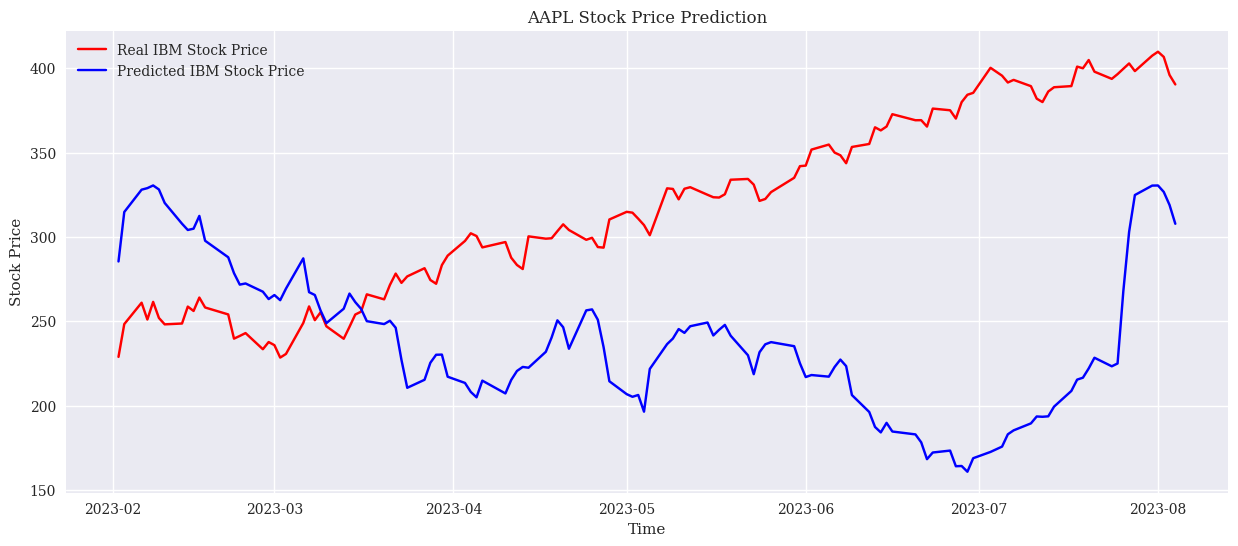

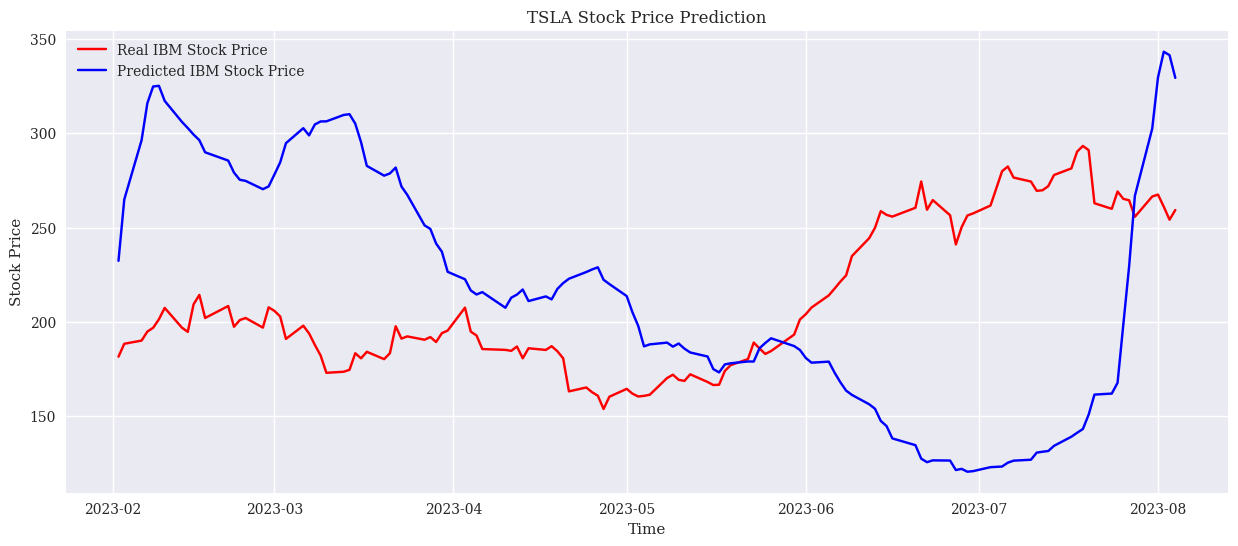

In [12]:
for symbol in symbols:
    # Visualising the results
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()

    axes.plot(df[symbol][len(df[symbol])-len(y_test[symbol]):].index, y_test[symbol], color = 'red', label = 'Real IBM Stock Price')
    axes.plot(df[symbol][len(df[symbol])-len(y_test[symbol]):].index, y_test_pred[symbol], color = 'blue', label = 'Predicted IBM Stock Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title(symbol + ' Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    # plt.savefig('ibm_pred.png')
    plt.show()